In [1]:
# Imports

# General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

# Deep Learning
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import plot_model

# Random Seed
import tensorflow as tf
tf.random.set_seed(2)

# Audio
import librosa.display, librosa

# Configurations
path = './audio/london_phill_dataset_multi/london_phill_dataset_multi'


In [2]:
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 700 audio files in ./audio/london_phill_dataset_multi/london_phill_dataset_multi


In [3]:
# Get Labels
labels =[]
classes=['cello', 'flute', 'guitar', 'oboe', 'sax', 'trumpet', 'viola']
color_dict={'cello':'blue', 'flute':'red', 'guitar':'orange','oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

In [4]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

7 classes: cello, flute, guitar, oboe, sax, trumpet, viola


In [5]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

In [6]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfccs,1)
    feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector



In [7]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
for i, f in enumerate(files):
    print("get %d of %d = %s" % (i + 1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y /= y.max()  # Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        mfccs = get_features(y, sr)
        feature_vectors.append(mfccs)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f, e))

print("Calculated %d feature vectors" % len(feature_vectors))

get 1 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_forte_arco-normal.mp3
get 2 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_fortissimo_arco-normal.mp3
get 3 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
get 4 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_mezzo-piano_arco-normal.mp3
get 5 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_pianissimo_arco-normal.mp3
get 6 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_05_forte_arco-normal.mp3
get 7 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_05_fortissimo_arco-normal.mp3
get 8 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_05_mezzo-piano_arco-normal.mp3
get 9 of 700 = 

In [8]:
# Scale features using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (700, 13)


In [9]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [10]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (525, 13)
test_set shape: (175, 13)
train_classes shape: (525,)
test_classes shape: (175,)


In [11]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

In [12]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

c:\Users\parik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\parik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [14]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (525, 1, 13)
test_set shape: (525, 1, 13)
train_classes shape: (525, 1, 7)
test_classes shape: (175, 1, 7)


In [15]:
# Creat Simple Model
model_input = Input(shape=(1,train_set.shape[1]))
fc1 = Dense(12, activation="relu")(model_input)
fc2 = Dense(10, activation="relu")(fc1)
fc3 = Dense(8, activation="relu")(fc2)
fc4 = Dense(6, activation="relu")(fc2)
n=onehot_encoded_train_classes.shape[1]
out = Dense(n, activation="softmax")(fc4)
model_d = Model(inputs=[model_input], outputs=[out])
model_d.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 13)]           0         
                                                                 
 dense (Dense)               (None, 1, 12)             168       
                                                                 
 dense_1 (Dense)             (None, 1, 10)             130       
                                                                 
 dense_3 (Dense)             (None, 1, 6)              66        
                                                                 
 dense_4 (Dense)             (None, 1, 7)              49        
                                                                 
Total params: 413 (1.61 KB)
Trainable params: 413 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Compile Model
model_d.compile(loss      = 'categorical_crossentropy',
              optimizer = SGD(learning_rate=0.05),
              metrics   =['accuracy'])

In [17]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 200    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = model_d.fit(train_set_d, train_classes_d_hot, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set_d,test_classes_d_hot))

Epoch 1/200


105/105 [==============================] - 1s 2ms/step - loss: 1.8544 - accuracy: 0.2876 - val_loss: 1.6601 - val_accuracy: 0.3200
Epoch 2/200
105/105 [==============================] - 0s 1ms/step - loss: 1.4837 - accuracy: 0.4248 - val_loss: 1.2887 - val_accuracy: 0.4743
Epoch 3/200
105/105 [==============================] - 0s 1ms/step - loss: 1.1233 - accuracy: 0.5924 - val_loss: 0.9062 - val_accuracy: 0.6857
Epoch 4/200
105/105 [==============================] - 0s 1ms/step - loss: 0.7949 - accuracy: 0.7067 - val_loss: 0.9224 - val_accuracy: 0.6171
Epoch 5/200
105/105 [==============================] - 0s 1ms/step - loss: 0.6397 - accuracy: 0.7543 - val_loss: 0.5521 - val_accuracy: 0.7771
Epoch 6/200
105/105 [==============================] - 0s 1ms/step - loss: 0.5862 - accuracy: 0.7790 - val_loss: 0.4861 - val_accuracy: 0.7829
Epoch 7/200
105/105 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.8133 - val_loss: 0.5254 - val_accuracy: 0.80

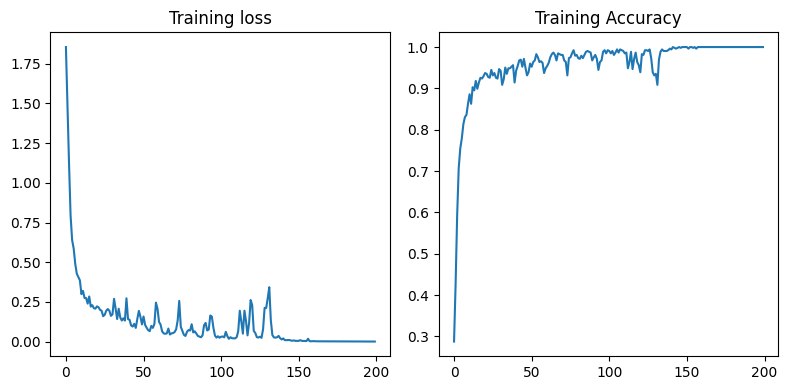

In [18]:
# Plot Training Loss and Training Accuracy
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Training loss")
plt.plot(range(epochs),hist.history["loss"])

plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(range(epochs),hist.history["accuracy"])

plt.tight_layout()

In [19]:
# Predict
predictions = model_d.predict(test_set_d)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=2)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

6/6 [==============================] - 0s 2ms/step


In [20]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negatives
print("Precision: ", precision_score(test_classes, predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision and recall,
print("F1-Score: ", f1_score(test_classes, predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: ", accuracy_score(test_classes, predictions_int,normalize=False))
print("Number of samples:",test_classes.shape[0])

Recall:  [0.8  0.88 0.96 0.96 0.84 0.92 1.  ]
Precision:  [0.95238095 0.91666667 1.         1.         0.95454545 0.79310345
 0.80645161]
F1-Score:  [0.86956522 0.89795918 0.97959184 0.97959184 0.89361702 0.85185185
 0.89285714]
Accuracy:  159
Number of samples: 175


In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predictions_int)
np.set_printoptions(precision=2)

In [22]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

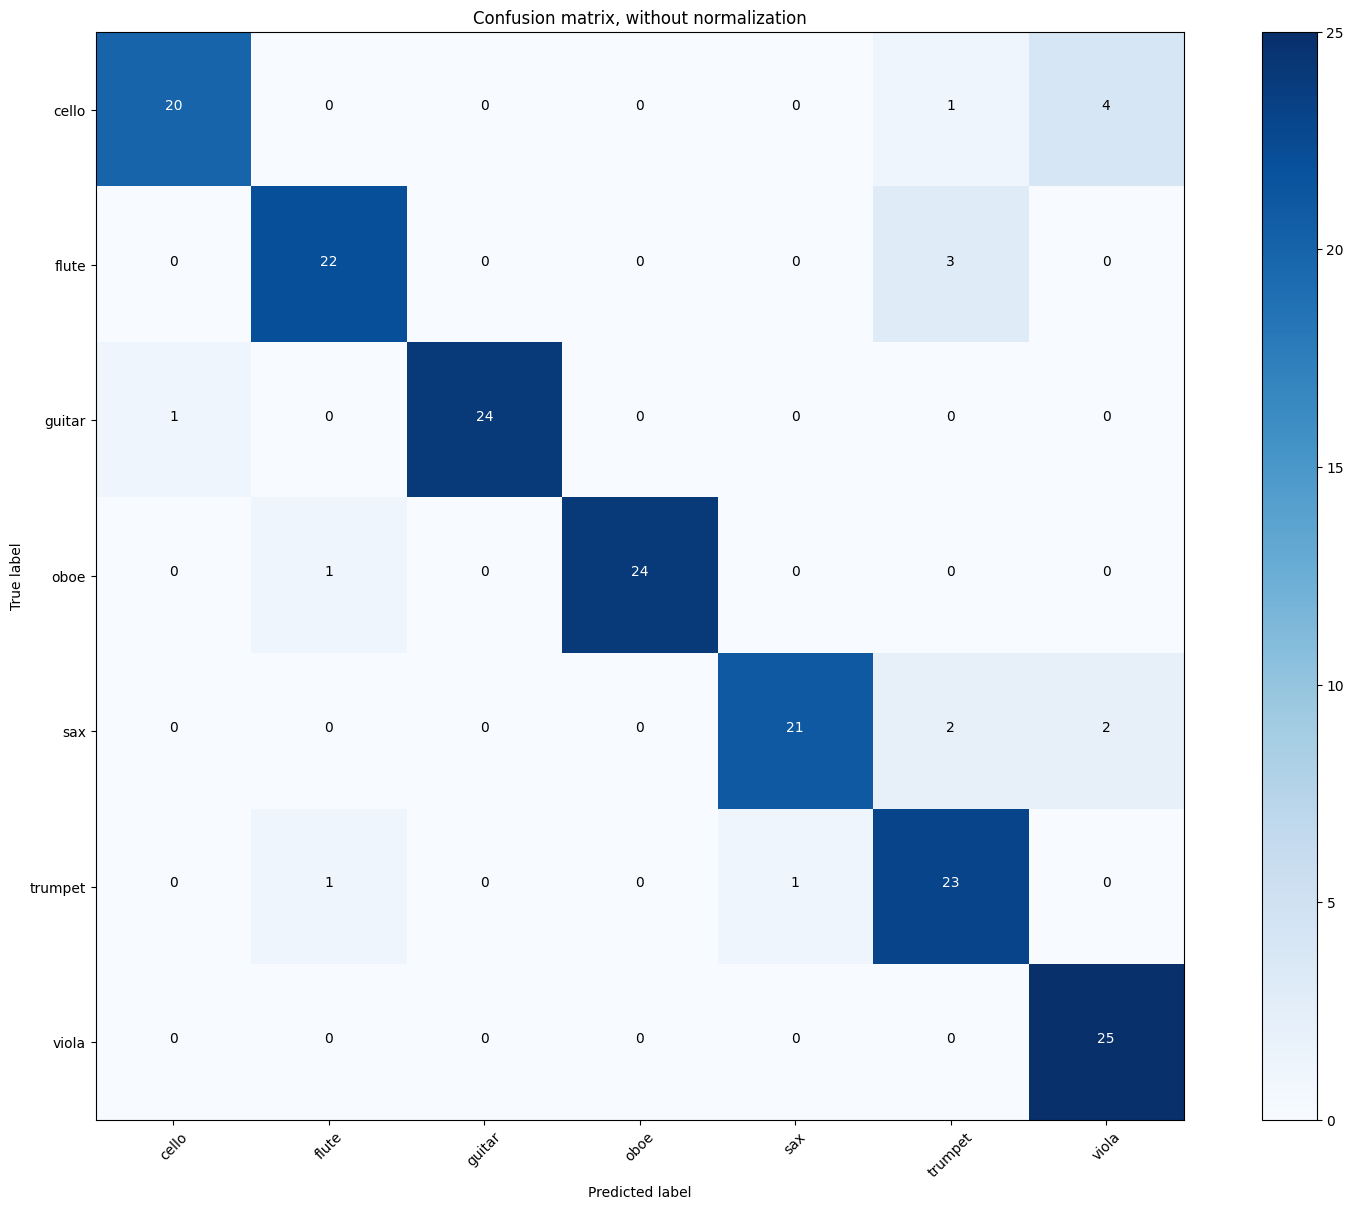

In [23]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [24]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predictions_int)) if e1 != e2]

In [25]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['flute' 'sax' 'flute' 'sax' 'cello' 'cello' 'oboe' 'cello' 'sax'
 'trumpet' 'trumpet' 'guitar' 'cello' 'sax' 'flute' 'cello']
['trumpet' 'viola' 'trumpet' 'viola' 'viola' 'viola' 'flute' 'viola'
 'trumpet' 'sax' 'flute' 'cello' 'trumpet' 'trumpet' 'trumpet' 'viola']
['./audio/london_phill_dataset_multi/london_phill_dataset_multi\\flute\\flute_A4_025_forte_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\sax\\saxophone_Ds4_05_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\flute\\flute_A5_025_mezzo-forte_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\sax\\saxophone_Ds4_05_piano_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\cello\\cello_Gs4_1_mezzo-piano_arco-normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\cello\\cello_Gs4_15_mezzo-piano_arco-normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\oboe\\oboe_A4

In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import FastICA

# Load the trained model
model = load_model('sounds.h5')

# Define the source separation function using ICA
def separate_sources(audio_path, model):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=44100)

    # Calculate features
    feature_vector = get_features(y, sr)

    # Make predictions
    predictions = model.predict(feature_vector)

    # Get predicted labels
    predictions_round = predictions.round().astype('int')
    predictions_int = np.argmax(predictions_round, axis=2)
    predictions_labels = labelencoder.inverse_transform(np.ravel(predictions_int))

    # Separate sources based on predicted labels
    separated_sources = []
    for label in predictions_labels:
        current_source = y[predictions_labels == label]

        # Apply ICA for further source separation
        ica = FastICA(n_components=2)
        ica_separated_sources = ica.fit_transform(current_source.reshape(1, -1))

        # Append ICA-separated sources to the list
        separated_sources.extend(ica_separated_sources)

    return separated_sources

# Import the mixed audio file
audio_path = 'mixed_audio.wav'

# Separate sources
separated_sources = separate_sources(audio_path, model)

# Save separated sources to separate files
for i, source in enumerate(separated_sources):
    librosa.save(source, f'separated_source_{i}.wav', sr=44100)


In [26]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

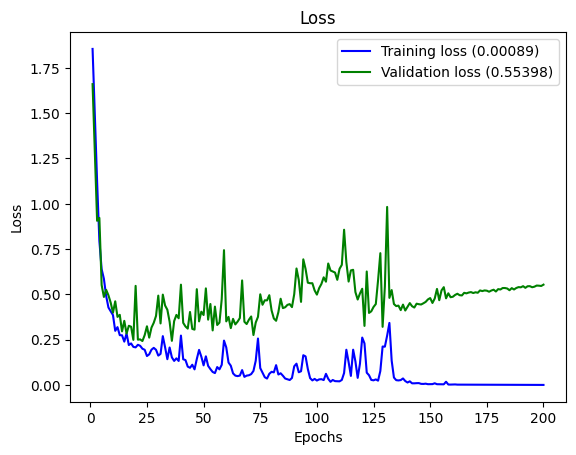

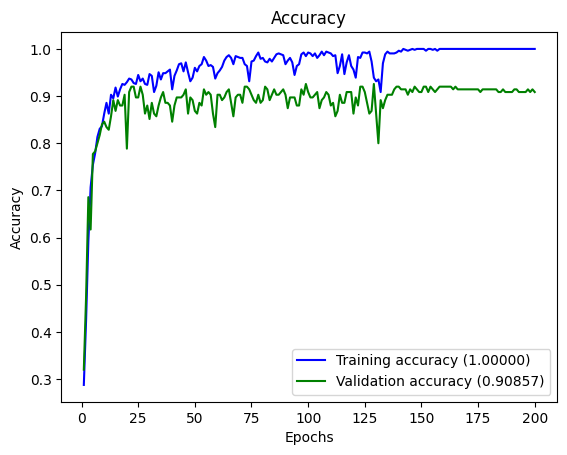

In [27]:
plot_history(hist)